In [23]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve

In [24]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [25]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [26]:
import os
import kagglehub

# Download latest version
path = kagglehub.dataset_download("navjotkaushal/human-vs-ai-generated-essays")

print("Path to dataset files:", path)



Using Colab cache for faster access to the 'human-vs-ai-generated-essays' dataset.
Path to dataset files: /kaggle/input/human-vs-ai-generated-essays


In [27]:
def preprocess_text(text):
    """text preprocessing function"""
    if not isinstance(text, str):
        return ""

    text = text.strip()
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    text = ' '.join(words)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [28]:
print(os.listdir(path))

['balanced_ai_human_prompts.csv']


In [29]:
data = pd.read_csv(os.path.join(path, 'balanced_ai_human_prompts.csv'))

In [30]:
#print the fist 5 rows
data.head(10)

,text,generated
0,"Machine learning, a subset of artificial intel...",1
1,"A decision tree, a prominent machine learning ...",1
2,"Education, a cornerstone of societal progress,...",1
3,"Computers, the backbone of modern technology, ...",1
4,"Chess, a timeless game of strategy and intelle...",1
5,"Calculus, a cornerstone of mathematical explor...",1
6,"Electronics, the backbone of modern technology...",1
7,"Data Science, a multidisciplinary field at the...",1
8,"Artificial Intelligence (AI), a branch of comp...",1
9,"Laptops, compact and portable computing device...",1


In [31]:
data.columns = ['text', 'generated']

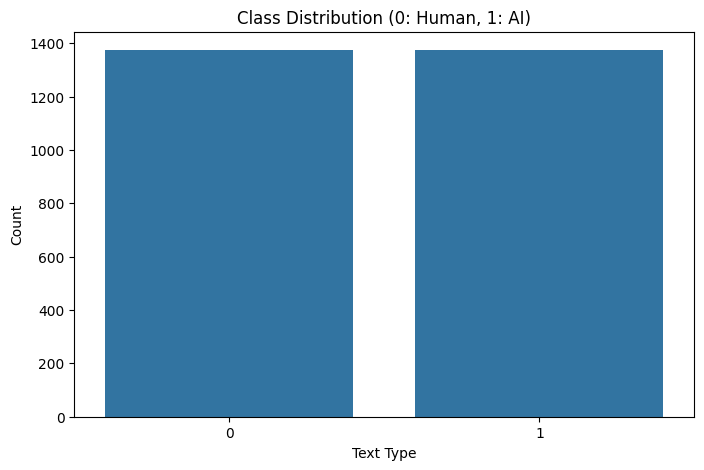

In [32]:
plt.figure(figsize=(8, 5))
sns.countplot(x='generated', data=data)
plt.title('Class Distribution (0: Human, 1: AI)')
plt.xlabel('Text Type')
plt.ylabel('Count')
plt.show()

In [33]:
# Drop NA/duplicates
data = data.dropna(subset=['text'])
data = data.drop_duplicates(subset=['text'])

# Normalize 'generated' column
data['generated'] = data['generated'].astype(str).str.lower().str.strip()

# Clean text by applying preprocess_text function
data['cleaned_text'] = data['text'].apply(preprocess_text)

# Remove empties or very short cleaned texts
data = data[data['cleaned_text'].str.len() > 0]

In [34]:
X = data['text']
y = data['generated']

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
X_data = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_data,y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape

((1936, 17644), (1936,))

Number of human texts after cleaning: 2772658
Number of AI texts after cleaning: 155374


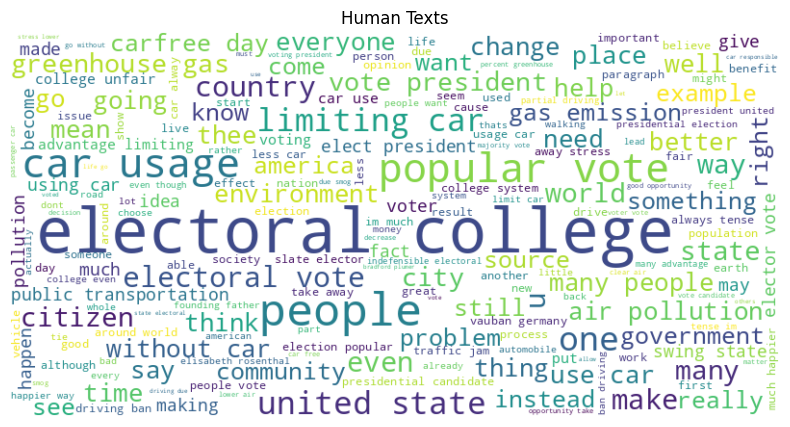

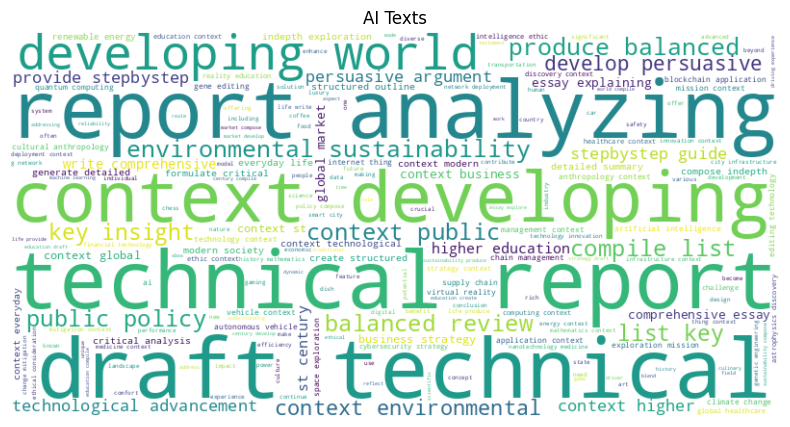

In [35]:
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Check for empty cleaned texts before plotting
human_text = ' '.join(data[data['generated'] == '0']['cleaned_text'])
ai_text = ' '.join(data[data['generated'] == '1']['cleaned_text'])

print(f"Number of human texts after cleaning: {len(human_text)}")
print(f"Number of AI texts after cleaning: {len(ai_text)}")

if human_text:
    plot_wordcloud(human_text, 'Human Texts')
else:
    print("No human text available for word cloud.")

if ai_text:
    plot_wordcloud(ai_text, 'AI Texts')
else:
    print("No AI text available for word cloud.")

In [36]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=5, max_df=0.7)
X_vectorized = vectorizer.fit_transform(X)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

In [38]:
classifier = LogisticRegression(max_iter=1000, class_weight='balanced')
classifier.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [39]:
y_pred_proba = classifier.predict_proba(X_test)[:, 1]
y_pred = classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9979338842975206

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       295
           1       1.00      0.99      1.00       189

    accuracy                           1.00       484
   macro avg       1.00      1.00      1.00       484
weighted avg       1.00      1.00      1.00       484



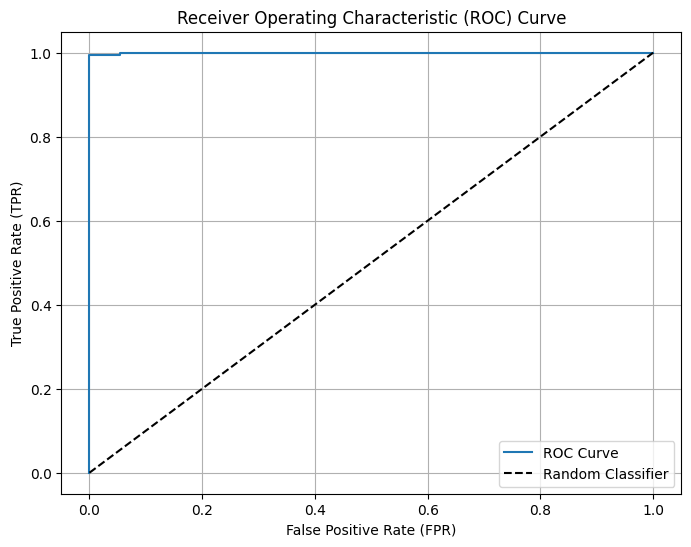

AUC: 1.000


In [40]:
from sklearn.metrics import roc_auc_score

# Convert y_test to integers
y_test_int = y_test.astype(int)

# 2. Calculate FPR and TPR
fpr, tpr, thresholds = roc_curve(y_test_int, y_pred_proba)

# 3. Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

# 4. Calculate AUC
auc = roc_auc_score(y_test_int, y_pred_proba)
print(f'AUC: {auc:.3f}')

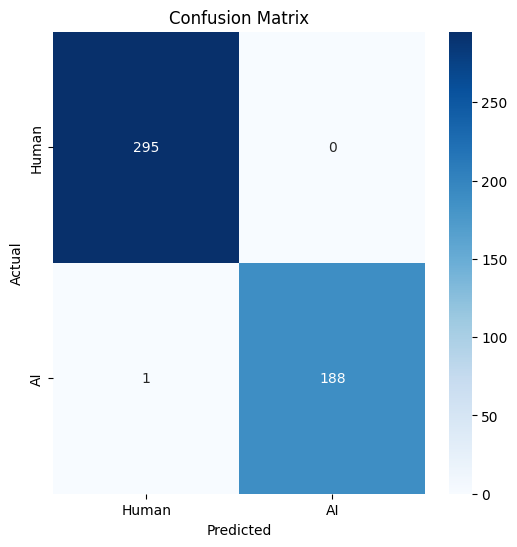

In [41]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Human', 'AI'],
                yticklabels=['Human', 'AI'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(y_test, y_pred)

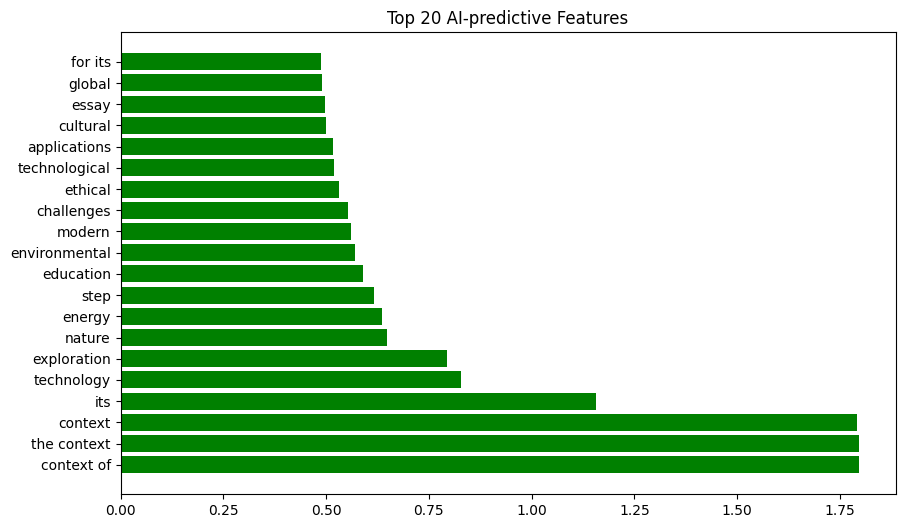

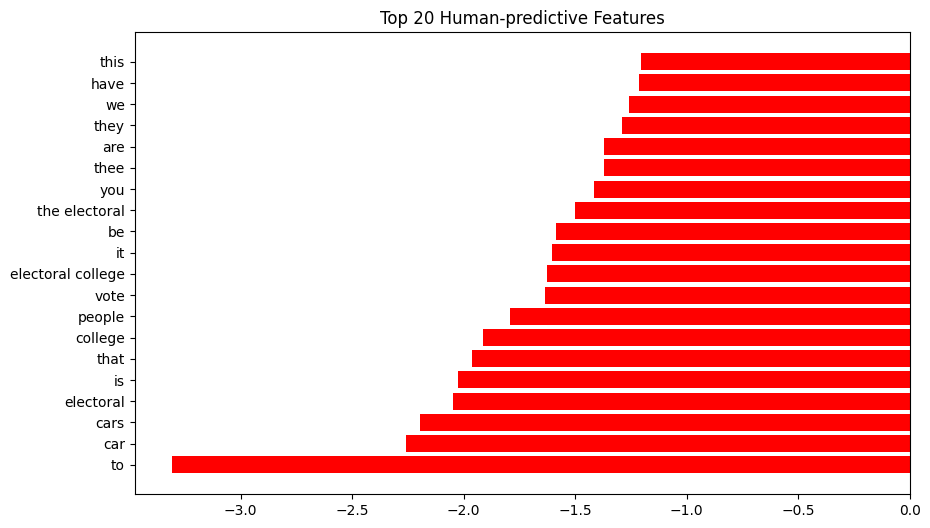

In [42]:
def plot_feature_importance(clf, vectorizer, top_n=20):
    feature_names = vectorizer.get_feature_names_out()
    coef = clf.coef_[0]
    top_positive = pd.DataFrame({'feature': feature_names, 'coef': coef}
                              ).sort_values('coef', ascending=False).head(top_n)
    top_negative = pd.DataFrame({'feature': feature_names, 'coef': coef}
                              ).sort_values('coef', ascending=True).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(top_positive['feature'], top_positive['coef'], color='green')
    plt.title(f'Top {top_n} AI-predictive Features')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.barh(top_negative['feature'], top_negative['coef'], color='red')
    plt.title(f'Top {top_n} Human-predictive Features')
    plt.show()

plot_feature_importance(classifier, vectorizer)

In [43]:
def classify_text(text):
    cleaned_text = preprocess_text(text)
    text_vectorized = vectorizer.transform([cleaned_text])
    prediction = classifier.predict(text_vectorized)
    return "AI-generated" if prediction[0] == 1 else "Human-written"

TEST

In [44]:
sample_text = "The economy, a complex system of production, distribution, and consumption of goods and services,"
print("\nSample classification:", classify_text(sample_text))


Sample classification: Human-written
